# 4. 캐글 경진대회 도전 (2) : 주택 가격 예측
## 4.1 더 상세하게 알아보는 데이터 분석
 - 데이터 분석 방법을 좀 더 상세히 알아보기
 - 여러 머신 러닝 방법의 설계 및 조합
 - 추가 분석 (1) : 클러스터 분석에 따른 주택 분류
 - 추가 분석 (2) : 고급 주택의 조건 분석 및 시각화
 
## 4.2 주택 가격 예측하기 경진대회란

예측 정확도 평가는 평균 제곱 오차(RMSE, Root Mean Squared Error)를 사용하며, 정답 데이터와 차이가 작을수록 상위를 차지합니다.


**분류(classification)**

|ID|Survived|
|-----|-----|
|0|1|
|1|1|
|2|0|
|3|1|
|4|0|

**회귀(regression)**

|ID|SalePrice|
|-----|-----|
|0|112,310|
|1|145,560|
|2|219,200|
|3|186,500|
|4|134,365|

평가 항목(evaluation)을 보면 Taking logs mean that errors in predicting expensive houses and cheap houses will affect the result equally

## 4.3 데이터 내려받기

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

In [2]:
import pandas as pd
import numpy as np

#### 랜덤 시드 설정하기

In [3]:
import random
np.random.seed(1234)
random.seed(1234)

#### CSV 데이터 불러오기(아나콘다(윈도), 맥에서 주피터 노트북 이용)

In [4]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/sample_submission.csv")

In [5]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 4.4 벤치마크용 베이스라인 작성

먼저 최소한의 카테고리 변수를 라벨 인코딩 처리한 후 LightGBM에 넣었을 때 정확도가 얼마인지 알아보겠습니다. 이것은 이후 처리가 정확도 향상에 얼마나 효과가 있었는지 검증하기 위해서 입니다.

### 4.4.1 LightGBM으로 예측

각 변수의 중요도를 나타낼 수 있기 때문에 향후 처리의 우선순위 등을 생각하는 지표로 활용될 수 있음

#### 학습 데이터의 변수 유형 확인하기
학습 데이터 각 변수의 유형을 **dtypes 명령어**로 확인할 수 있습니다

In [6]:
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [7]:
train_df["MSZoning"].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

#### 학습 데이터와 테스트 데이터를 합해서 전처리하기
LabelEncoder는 카테고리를 연속적인 수치로 변환합니다. 이때 **주의할 점**은 학습 데이터만 변환시킬 때는 테스트 데이터에만 존재하는 변수를 만나면 오류를 발생한다는 것

LabelEncoder를 처리하기 전에 결측치(NaN)를 미리 임의의 문자열(예를 들어 missing 등)로 변환하거나 삭제

data discription 파일에서 NA인 것에 의미가 있다면(예를 들어 차고(Garage) 값이 NaN일 때는 차고가 없다는 의미) NaN을 삭제하기보다 missing처럼 결손을 나타내는 다른 값으로 대체하는 것이 좋다.

판다스의 데이터프레임은 pd.concat() 함수로 연결할 수 있습니다. 인덱스가 중복되므로 reset_index() 함수로 인덱스 새로 매김, (drop=True) 옵션을 이용하여 원래 index 행은 삭제

In [8]:
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)
all_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


In [9]:
all_df["SalePrice"]

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
2914         NaN
2915         NaN
2916         NaN
2917         NaN
2918         NaN
Name: SalePrice, Length: 2919, dtype: float64

#### 카테고리 변수를 수치로 변환하기
all_df의 object형 카테고리 변수를 수치로 변환. 우선은 LabelEncoder의 라이브러리를 불러옵니다.

In [10]:
from sklearn.preprocessing import LabelEncoder
categories = all_df.columns[all_df.dtypes=="object"]
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [11]:
all_df["Alley"].value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

#### 결측치를 수치로 변환하기
categories에 저장된 카테고리 변수를 하나씩 호출하여 결측치를 missing으로 변환한 후 LabelEncoder를 사용하여 수치로 바꾸어 줍니다. 단순한 숫자로 변환되므로 이것이 카테고리 변수임을 명시하고자 마지막에 astype("category")로 하겠습니다.

In [12]:
for cat in categories:
    le = LabelEncoder()
    print(cat)
    
    all_df[cat].fillna("missing", inplace=True) #
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [13]:
all_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,208500.0
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,181500.0
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,223500.0
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,140000.0
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,4,21.0,1936,1,2,3,3,0,...,0,3,4,4,0,6,2006,8,4,NaN
2915,2916,160,4,21.0,1894,1,2,3,3,0,...,0,3,4,4,0,4,2006,8,0,NaN
2916,2917,20,3,160.0,20000,1,2,3,3,0,...,0,3,4,4,0,9,2006,8,0,NaN
2917,2918,85,3,62.0,10441,1,2,3,3,0,...,0,3,2,2,700,7,2006,8,4,NaN


#### 학습 데이터와 테스트 데이터로 되돌리기

이렇게 해서 LightGBM 등 각종 머신 러닝 모델에서 데이터를 읽을 수 있게 되었습니다. 이제 다시 train_df와 test_df로 되돌려 놓겠습니다.

isnull()로 null 행을 판정할 수 있는데, all_df["SalePrice"].isnull()을 실행하여 SalePrice의 null 행을 분리하면 이것이 테스트 데이터가 됩니다.

In [14]:
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

#### LightGBM으로 데이터 읽기

In [15]:
import lightgbm as lgb

### 4.4.2 교차 검증으로 모델 학습과 예측
이제 학습 데이터를 세 개로 분할하고, 각 데이터로 모델을 작성한 후 테스트 데이터에 대한 예측 정확도 평균을 구해 보겠습니다.

#### 교차 검증용 라이브러리 설정하기
우선 교차 검증용 라이브러리를 불러오고, 분할할 데이터 수를 3으로 설정합니다


In [16]:
from sklearn.model_selection import KFold
folds = 3
kf = KFold(n_splits=folds)

#### 하이퍼 파라미터 설정하기
다음으로 LightGBM의 하이퍼파라미터 설정합니다. 나중에 다시 조정하기 때문에 여기서는 일단 회귀 분석용 모델인 Objective, regression만 설정하겠습니다.

In [17]:
lgbm_params = {
    "objective" : "regression",
    "random_sedd" : 1234
}

#### 설명 변수와 목적 변수 지정하기
교차 검증을 수행하기 전에 설명 변수와 목적 변수를 지정합니다. 목적 변수는 SalePrice입니다. 설명 변수는 원래 데이터에서 SalePrice와 학습에 불필요한 Id를 삭제하는 것입니다.

In [18]:
train_X = train_df_le.drop(["SalePrice", "Id"], axis = 1)
train_Y = train_df_le["SalePrice"]

#### 평균 제곱 오차 라이브러리 불러오기
이번 경진대회의 평기 지표가 RMSE이므로 이를 구하는 라이브러리도 임포트합니다. RMSE는 평균 제곱 오차 제곱근이므로, 평균 제곱 오차를 구하는 라이브러리를 임포트 합니다.

In [19]:
from sklearn.metrics import mean_squared_error

#### 모델별 예측 값 저장하기
fold별로 작성한 모델을 models에 저장하고, rmse의 계산 결과를 rmses에 저장합니다. 동시에 oof(out of fold)(해당 데이터를 제외한 나머지 데이터를 이용하여 목적 변수를 예측한 값)를 저장합니다.

off는 초깃값을 0으로 하고, fold마다 해당하는 인덱스 값을 갱신합니다. np.zeros() 함수로 임의의 길이만큼 0으로 채운 배열(정확히는 넘파이의 ndarray, 같은 유형의 값을 저장할 수 있는 다차원 배열)을 작성할 수 있습니다. kf.split() 함수로 train_X를 분할한 결과의 인덱스를 얻고, 이를 바탕으로 학습 데이터와 검증 데이터를 지정한 후 LightGBM을 실행하겠습니다

In [20]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    
    model_lgb = lgb.train(lgbm_params,
                         lgb_train,
                         valid_sets = lgb_eval,
                         num_boost_round = 100,
                         early_stopping_rounds = 20,
                         verbose_eval = 10,
                         )
    
    y_pred = model_lgb.predict(X_valid, num_iteration = model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
    print(tmp_rmse)
    
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 1.59541e+09
[20]	valid_0's l2: 7.467e+08
[30]	valid_0's l2: 5.96558e+08
[40]	valid_0's l2: 5.49479e+08
[50]	valid_0's l2: 5.29299e+08
[60]	valid_0's l2: 5.28785e+08
[70]	valid_0's l2: 5.32577e+08
Early stopping, best iteration is:
[57]	valid_0's l2: 5.26368e+08
0.12637668452645173
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 2.08125e+09
[20]	valid_0's l2: 1.23117e+09
[30]	valid_0's l2: 1.04155e+09
[40]	valid_0's l2: 9.92123e+08
[50]	valid_0's l2: 9.69222e+08
[60]	valid_0's l2: 9.54807e+08
[70]	valid_0's l2: 9.50536e+08
[80]	valid_0's l2: 9.45353e+08
[90]	valid_0's l2: 9.40359e+08
[100]	valid_0's l2: 9.36486e+08
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 9.36066e+08
0.15229205843857013
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 1.78839e+09
[20]	valid_0's l2: 1.03494e+09
[30]	valid_0's l2: 8.77181e+08
[40]	valid_0'

#### 평균 RMSE 계산하기
리스트 합계를 sum()으로 구하고 len()에서 리스트의 요소 개수를 구해서 합계를 요소 개수로 나누어 평균을 냅니다.

In [21]:
sum(rmses)/len(rmses)

0.13697846250952908

In [22]:
from statistics import mean
mean(rmses)

0.13697846250952908

#### 현재 예측 값과 실제 값 차이 확인하기
예측 값은 off고, 실제 값은 train_Y이므로 이 정보를 데이터 프레임에 저장한 후 시각화해 보겠습니다.

<AxesSubplot:>

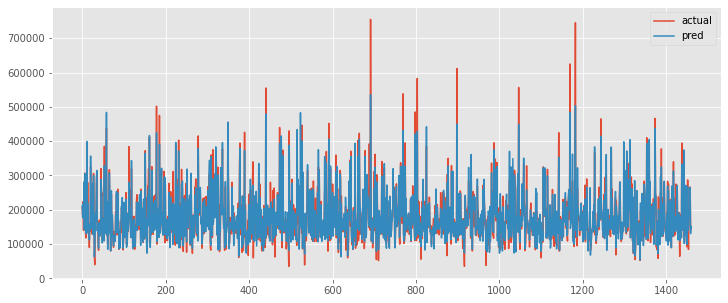

In [23]:
actual_pred_df = pd.DataFrame({
    "actual" : train_Y,
    "pred" : oof
})

actual_pred_df.plot(figsize=(12, 5))

### 4.4.3 각 변수의 중요도 확인
현재 모델의 변수별 중요도를 확인해 봅시다.

#### 표시된 변수의 수를 제한하기
단 이대로 변수가 너무 많아서 한 번에 모두 표시하면 결과를 알아보기 어렵습니다. 따라서 max_num_features에서 표시하는 변수의 수를 제한하겠습니다.

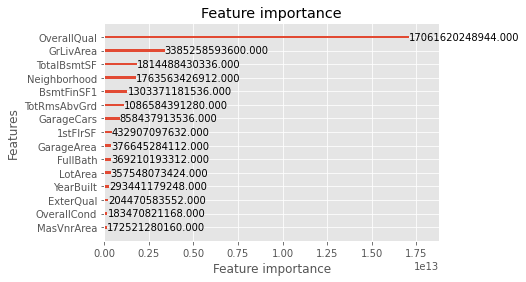

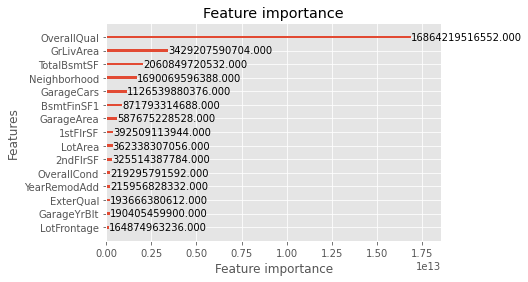

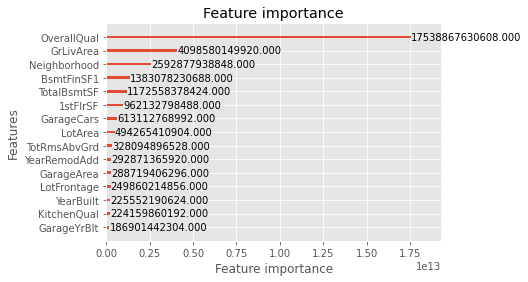

In [24]:
for model in models:
    lgb.plot_importance(model, importance_type="gain", max_num_features=15)

## 4.5 목적 변수의 전처리 : 목적 변수의 분포 확인
이제부터는 다양한 변수를 상세하게 확인하면서 각종 처리를 해 보겠습니다.

### 4.5.1 SalePrice 데이터의 분포 확인
먼저 예측하려는 SalePrice 데이터의 분포를 확인합니다.

#### SalePrice의 각 통계량 확인하기
우선 describe()로 각종 통계량을 확인합니다.

In [25]:
train_df["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

#### 히스토그램으로 SalePrice 분포 확인하기
계속해서 plot.hist()로 히스토그램 그려 보겠습니다. bins=를 지정하면 히스토그램의 빈(데이터를 같은 간격으로 보여 주는 히스토그램 막대) 개수를 지정할 수 있습니다.

푸아송 분포 - 왼쪽으로 치우쳐짐

<AxesSubplot:ylabel='Frequency'>

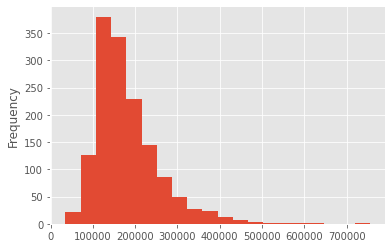

In [26]:
train_df["SalePrice"].plot.hist(bins=20)

#### 목적 변수를 로그화하기

일반적으로 머신 러닝이나 통계적인 처리 대부분은 데이터가 정규 분포임을 상정하고 있습니다. 또 언뜻 보기에 16만 달러 부근에 데이터가 많이 존재하고 있으므로 그 차이를 50~60만 달러 사이의 차이보다 상세하게 파악할 수 있도록 조사해야 할 것 같습니다. 이 경진대회에서 평가 지표는 실제 값 로그와 예측 값 로그의 RMSE가 됩니다.

그 때문에 목젹 변수를 로그화하는 편이 평가 지표를 최적화하기가 쉬워집니다.

In [27]:
np.log(train_df['SalePrice'])

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

<AxesSubplot:ylabel='Frequency'>

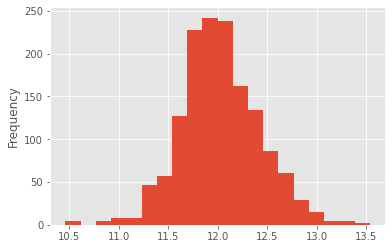

In [28]:
np.log(train_df["SalePrice"]).plot.hist(bins=20)

#### 목적 벽수를 로그화하여 예측 정확도 향상시키기

목적 변수를 로그화하는 것만으로도 예측 정확도가 향상되는지 확인해 보겠습니다. 조금 전 실행 코드와 거의 같습니다만, RMSE를 구할 때 이미 목적 변수를 로그화했습니다. 이미 로그화를 진행했으므로 이중으로 로그를 취하지 않도록 주의합시다.

In [29]:
pd.options.mode.chained_assignment = None
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])

In [30]:
train_X = train_df_le.drop(["SalePrice", "SalePrice", "Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [31]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    
    model_lgb = lgb.train(lgbm_params,
                         lgb_train,
                         valid_sets = lgb_eval,
                         num_boost_round = 100,
                         early_stopping_rounds = 20,
                         verbose_eval = 10,
                         )
    
    y_pred = model_lgb.predict(X_valid, num_iteration = model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)
    
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.018594
[20]	valid_0's l2: 0.00292564
[30]	valid_0's l2: 0.00159073
[40]	valid_0's l2: 0.00168549
[50]	valid_0's l2: 0.00182901
Early stopping, best iteration is:
[32]	valid_0's l2: 0.00156302
0.03953504672444025
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0272018
[20]	valid_0's l2: 0.00801312
[30]	valid_0's l2: 0.00512159
[40]	valid_0's l2: 0.0043896
[50]	valid_0's l2: 0.00416068
[60]	valid_0's l2: 0.00407619
[70]	valid_0's l2: 0.00406519
[80]	valid_0's l2: 0.00408173
Early stopping, best iteration is:
[66]	valid_0's l2: 0.00404355
0.06358891711818161
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0189739
[20]	valid_0's l2: 0.00318623
[30]	valid_0's l2: 0.00129945
[40]	valid_0's l2: 0.00118187
[50]	valid_0's l2: 0.00116062
[60]	valid_0's l2: 0.00117235
[70]	valid_0's l2: 0.00118837
Early stopping, best iteration is:
[55]	valid_0's l2

In [32]:
sum(rmses)/len(rmses)

0.04565463825543347

## 4.6 설명 변수의 전처리: 결측치 확인

### 4.6.1 각 설명 변수의 결측치 확인
각 설명 변수에 결측치가 얼마나 포함되어 있는지 확인해 봅시다. 이번 데이터의 결측치는 단순한 입력 실수가 아니라 의미가 있다는 점에 주의합시다. 예를 들어 data discription 파일에 나온 대로 PoolQC(수영장의 퀄리티)가 결측치로 나온다면 '수영장이 존재하지 않는다'는 의미입니다.

#### all_df 생성하기

In [33]:
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

In [34]:
categories = all_df.columns[all_df.dtypes=="object"]
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


#### 결측치 수가 상위 40인 변수 확인하기

isnull()로 결측치가 있는지 여부를 확인할 수 있으며, sum() 함수로 결측치의 수를 알 수 있습니다. 결측치의 수가 많은 것부터 내림차순으로 확인하려면 sort_values(ascending=False)라고 입력해야 합니다. sort_values() 함수로 주어진 값을 정렬하며, ascending=False로 내림차순 옵션을 줍니다. 이제 head(40)으로 상위 40까지 변수들을 확인해 보겠습니다(상위 40으로 설정한 것은 결측치가 많은 순으로 정렬했을 때 35번째 변수 이후로는 결측치 값이 계속해서 0이기 때문)

In [35]:
all_df.isnull().sum().sort_values(ascending=False).head(40)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageFinish      159
GarageQual        159
GarageCond        159
GarageYrBlt       159
GarageType        157
BsmtExposure       82
BsmtCond           82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MasVnrArea         23
MSZoning            4
Functional          2
BsmtHalfBath        2
BsmtFullBath        2
Utilities           2
BsmtFinSF1          1
BsmtFinSF2          1
SaleType            1
Electrical          1
GarageCars          1
TotalBsmtSF         1
GarageArea          1
Exterior2nd         1
Exterior1st         1
KitchenQual         1
BsmtUnfSF           1
Fireplaces          0
TotRmsAbvGrd        0
SaleCondition       0
OpenPorchSF         0
YrSold              0
dtype: int64

SalsePrice는 테스트 데이터에 포함되어 있지 않기 때문에 굘손이 있는 것이 당연합니다. PoolQC, MiscFeature, Alley, Fence등은 상당히 많은 결손(80% 이상의 결손)이 있습니다. 그리고 조금 전에 중요도가 높은 변수로 나왔던 Garage 계열의 변수도 몇개 결손되어 있습니다. 이 변수를 제외할 것인지 추가로 계산하여 보완할 것인지 검토하겠습니다.

#### 결측치가 많은 고급 주택 설비에 관한 변수 정리하기
90% 이상의 데이터가 결손된 PoolQC, MiscFeature, Alley 등 고급 주택 관련 설비 항목은 대부분 값이 없습니다. 따라서 이 변수들은 모두 '고급 설비의 유무' 변수로 변환한 후 원래 데이터는 삭제 하겠습니다.

In [36]:
all_df.PoolQC.value_counts()

Ex    4
Gd    4
Fa    2
Name: PoolQC, dtype: int64

In [37]:
all_df.loc[~all_df["PoolQC"].isnull(), "PoolQC"] = 1
all_df.loc[all_df["PoolQC"].isnull(), "PoolQC"] = 0

In [38]:
all_df.PoolQC.value_counts()

0    2909
1      10
Name: PoolQC, dtype: int64

In [39]:
HighFacility_col = ["PoolQC", "MiscFeature", "Alley"]
for col in HighFacility_col:
    if all_df[col].dtype == "object":
        if len(all_df[all_df[col].isnull()]) > 0:
            all_df.loc[~all_df[col].isnull(), col] = 1
            all_df.loc[all_df[col].isnull(), col] = 0

In [40]:
all_df["hasHighFacility"] = all_df["PoolQC"] + all_df["MiscFeature"] + all_df["Alley"]
all_df["hasHighFacility"] = all_df["hasHighFacility"].astype(int)

In [41]:
all_df["hasHighFacility"].value_counts()

0    2615
1     295
2       9
Name: hasHighFacility, dtype: int64

In [43]:
all_df = all_df.drop(["PoolQC", "MiscFeature", "Alley"], axis = 1)

## 4.7 이상치 제외

데이터 중에 크기가 너무 넓거나 방 개수가 너무 많은 주택 등 일반적인 경향과 다른 데이터가 있는지 살펴보겠습니다.

### 4.7.1 이상치란

통상적인 경향과 다른 값을 이상치(outlier)라고 합니다. 이상치가 데이터 내에서 존재하면 과적합 가능성이 있어 예측 정확도가 떨어집니다.

### 4.7.2 각 설명 변수의 데이터 분포 확인

#### 각 변수의 통계량 확인하기

In [45]:
all_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,hasHighFacility
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000,2919.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,...,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890,0.107229
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,...,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883,0.319268
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,0.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000,0.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,...,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000,0.000000
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,...,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000,0.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000,2.000000


In [46]:
all_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2919.0,1460.000000,842.787043,1.0,730.5,1460.0,2189.5,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0


#### 수치 데이터만 추출하기

먼저 이상치를 확인하고자 수치 데이터만 추출해 보겠습니다. 수치 데이터 여부는 np.number로 파악할 수 있습니다.

In [48]:
train_df_num = train_df.select_dtypes(include=[np.number])
train_df_num

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,366,0,112,0,0,0,0,4,2010,142125


In [50]:
nonratio_features = ["Id", "MSSubClass", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd", "MoSold", "YrSold"]

In [52]:
num_features = sorted(list(set(train_df_num) - set(nonratio_features)))
num_features

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF',
 'PoolArea',
 'SalePrice',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF']

In [53]:
train_df_num_rs = train_df_num[num_features]

#### 다수의 데이터가 0인 변수 확인하기

결측치는 아니지만 대부분 0으로 채워진 변수가 없는지 확인하겠습니다. describe()로 조금 전 만든 데이터의 통계량을 낸 후 3/4분위수가 0, 즉 전체 75% 이상의 값이 0이 되는 변수 목록을 보겠습니다.

In [54]:
for col in num_features:
    if train_df_num_rs.describe()[col]["75%"] == 0:
        print(col, len(train_df_num_rs[train_df_num_rs[col]==0]))

3SsnPorch 1436
BsmtFinSF2 1293
BsmtHalfBath 1378
EnclosedPorch 1252
LowQualFinSF 1434
MiscVal 1408
PoolArea 1453
ScreenPorch 1344


#### 특정 값만 가지는 변수 확인하기

다음으로 특정한 값만 취하는 변수를 확인하겠습니다. 예를 들어 BsmtHalfBath '변기만 있는 화장실' 개수를 의미 0, 1, 2 이렇게 세 개만 있는 것. 이들 변수를 카테고리 변수로 변환하거나 존재 유무(0 또는 1)를 나타내는 데이터로 변환하는 것을 검토

In [55]:
for col in num_features:
    if train_df_num_rs[col].nunique() < 15:
        print(col, train_df_num_rs[col].nunique())

BedroomAbvGr 8
BsmtFullBath 4
BsmtHalfBath 3
Fireplaces 4
FullBath 4
GarageCars 5
HalfBath 3
KitchenAbvGr 4
PoolArea 8
TotRmsAbvGrd 12


#### 이상치가 있는지 확인하기
여러 방법이 있지만, 간단히 '평균에서 표준 편차+- 3배 범위에 들어 있지 않은 것'이라고 하겠습니다. 

In [60]:
for col in num_features:
    tmp_df = train_df_num_rs[(train_df_num_rs[col] > train_df_num_rs[col].mean() + train_df_num_rs[col].std() *3) | 
                            (train_df_num_rs[col] < train_df_num_rs[col].mean() - train_df_num_rs[col].std() *3)]
    print(col, len(tmp_df))

1stFlrSF 12
2ndFlrSF 4
3SsnPorch 23
BedroomAbvGr 14
BsmtFinSF1 6
BsmtFinSF2 50
BsmtFullBath 16
BsmtHalfBath 82
BsmtUnfSF 11
EnclosedPorch 51
Fireplaces 5
FullBath 0
GarageArea 7
GarageCars 0
GarageYrBlt 1
GrLivArea 16
HalfBath 12
KitchenAbvGr 68
LotArea 13
LotFrontage 12
LowQualFinSF 20
MasVnrArea 32
MiscVal 8
OpenPorchSF 27
PoolArea 7
SalePrice 22
ScreenPorch 55
TotRmsAbvGrd 12
TotalBsmtSF 10
WoodDeckSF 22


#### 이상치를 포함하는 변수 분포를 시각화하기
세로축을 목적 변수인 SalePrice로 하고, 가로축에는 각 변수를 놓겠습니다. 흩어진 정도를 보여 주는 산포도(scatter plot)는 plot.scatter 함수를 이용해서 그릴 수 있습니다.

<AxesSubplot:xlabel='BsmtFinSF1', ylabel='SalePrice'>

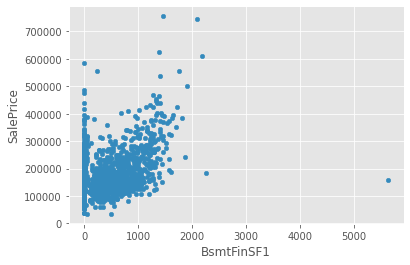

In [61]:
all_df.plot.scatter(x="BsmtFinSF1", y="SalePrice")

In [64]:
all_df[all_df["BsmtFinSF1"] > 5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1


<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

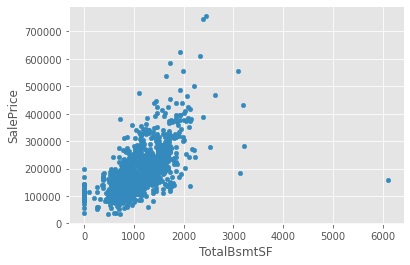

In [63]:
all_df.plot.scatter(x="TotalBsmtSF", y="SalePrice")

In [65]:
all_df[all_df["TotalBsmtSF"] > 5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

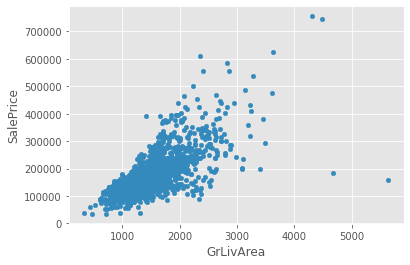

In [66]:
all_df.plot.scatter(x="GrLivArea", y="SalePrice")

In [67]:
all_df[all_df["GrLivArea"] > 5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

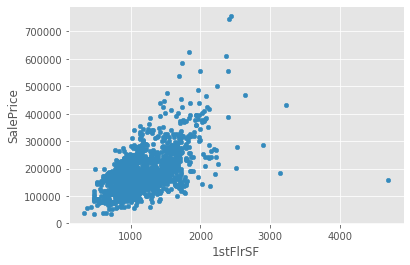

In [68]:
all_df.plot.scatter(x="1stFlrSF", y="SalePrice")

In [69]:
all_df[all_df["1stFlrSF"] > 4000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0
